## Load and Prepare Data


In [78]:
pip install netcdf4 h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [79]:
pip install scikit-learn xarray pandas numpy matplotlib seaborn sktime xgboost

Note: you may need to restart the kernel to use updated packages.


In [80]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    confusion_matrix,
)
from sktime.split import temporal_train_test_split
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb

import warnings

warnings.filterwarnings("ignore")

# Set seaborn style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [81]:
# Data path
DATA_PATH = Path("../../0_data/bissau_merged.nc")

# Center cell indices (for 5x5 grid)
CENTER_LAT_IDX = 2
CENTER_LON_IDX = 2

# Rain threshold (mm)
RAIN_THRESHOLD = 0.1

print(f"Data path: {DATA_PATH}")
print(f"Rain threshold: {RAIN_THRESHOLD} mm")

Data path: ..\..\0_data\bissau_merged.nc
Rain threshold: 0.1 mm


In [82]:
# Load NetCDF4 with xarray
ds = xr.open_dataset(DATA_PATH)

# Convert timestamps to datetime
time_values = pd.to_datetime(ds.valid_time.values)

# Extract center cell data & apply unit conversions
t2m_center = ds.t2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
d2m_center = ds.d2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
tcc_center = ds.tcc[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 100  # fraction → %
sp_center = ds.sp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values / 100  # Pa → hPa
tp_center = ds.tp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 1000  # m → mm

# Create DataFrame with datetime index
df = pd.DataFrame(
    {
        "datetime": time_values,
        "t2m": t2m_center,  # Temperature (°C)
        "d2m": d2m_center,  # Dewpoint (°C)
        "tcc": tcc_center,  # Cloud cover (%)
        "sp": sp_center,  # Surface pressure (hPa)
        "tp": tp_center,  # Precipitation (mm)
    }
)
df.set_index("datetime", inplace=True)


# Calculate Relative Humidity using Magnus formula
def calc_relative_humidity(t2m, d2m):
    a, b = 17.625, 243.04
    rh = 100 * np.exp((a * d2m) / (b + d2m)) / np.exp((a * t2m) / (b + t2m))
    return np.clip(rh, 0, 100)


df["rh"] = calc_relative_humidity(df["t2m"].values, df["d2m"].values)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nBasic statistics:")
df.describe().round(2)

Data shape: (18263, 6)
Date range: 1975-01-01 00:00:00 to 2024-12-31 00:00:00

Basic statistics:


,t2m,d2m,tcc,sp,tp,rh
count,18263.00,18263.00,18263.00,18263.00,18263.00,18263.00
mean,24.93,20.85,56.09,1011.19,0.10,79.89
std,1.64,4.56,40.24,1.63,0.53,16.09
min,18.62,0.08,0.00,1005.20,0.00,21.22
25%,23.99,19.05,10.79,1010.07,0.00,74.01
50%,25.13,22.68,66.50,1011.18,0.00,86.25
75%,26.07,24.03,97.31,1012.32,0.00,91.38
max,31.38,27.67,100.00,1017.49,24.93,99.86


## Binarize Target Variable

Create binary target: Rain (tp > 0.1mm) vs No Rain


BINARY TARGET DISTRIBUTION (threshold: 0.1 mm)

No Rain (0): 16,284 days (89.2%)
Rain (1):    1,979 days (10.8%)

Class imbalance ratio: 8.23:1


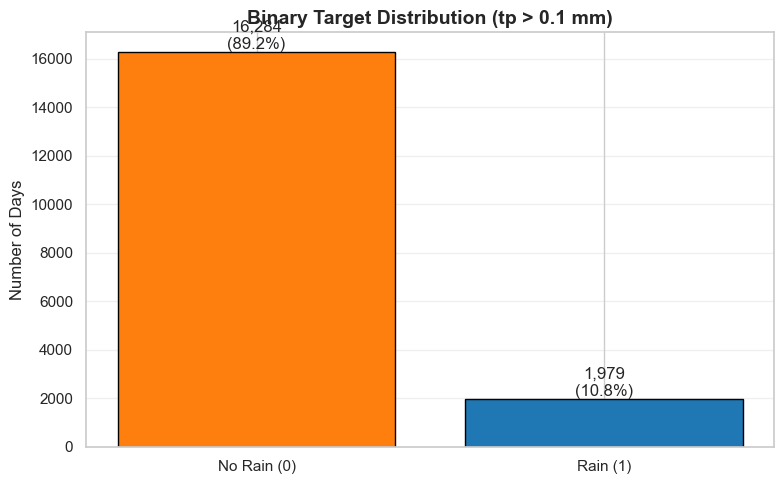

In [83]:
# Binarize precipitation: Rain vs No Rain
df["rain_binary"] = (df["tp"] > RAIN_THRESHOLD).astype(int)

# Check class distribution
class_counts = df["rain_binary"].value_counts()
class_pct = df["rain_binary"].value_counts(normalize=True) * 100

print("=" * 50)
print(f"BINARY TARGET DISTRIBUTION (threshold: {RAIN_THRESHOLD} mm)")
print("=" * 50)
print(f"\nNo Rain (0): {class_counts[0]:,} days ({class_pct[0]:.1f}%)")
print(f"Rain (1):    {class_counts[1]:,} days ({class_pct[1]:.1f}%)")
print(f"\nClass imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#ff7f0e", "#1f77b4"]
bars = ax.bar(
    ["No Rain (0)", "Rain (1)"], class_counts.values, color=colors, edgecolor="black"
)
ax.bar_label(
    bars,
    labels=[
        f"{c:,}\n({p:.1f}%)" for c, p in zip(class_counts.values, class_pct.values)
    ],
)
ax.set_ylabel("Number of Days")
ax.set_title(
    f"Binary Target Distribution (tp > {RAIN_THRESHOLD} mm)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Engineering

Add temporal features:

- Lag features (1, 2, 3, 7 days)
- Rolling statistics (7-day, 30-day mean/std)
- Lag 1 year (365 days)
- Lag 1 year rolling average


In [84]:
def create_lag_features(df, base_features, lags=[1, 2, 3, 7]):
    """Create lag features for specified columns."""
    df_feat = df.copy()
    for feat in base_features:
        for lag in lags:
            df_feat[f"{feat}_lag{lag}"] = df_feat[feat].shift(lag)
    return df_feat


def create_rolling_features(df, base_features, windows=[7, 30]):
    """Create rolling mean and std features."""
    df_feat = df.copy()
    for feat in base_features:
        for window in windows:
            df_feat[f"{feat}_rollmean{window}"] = (
                df_feat[feat].shift(1).rolling(window).mean()
            )
            df_feat[f"{feat}_rollstd{window}"] = (
                df_feat[feat].shift(1).rolling(window).std()
            )
    return df_feat


def create_yearly_lag_features(df, base_features):
    """Create lag 1 year and lag 1 year rolling average features."""
    df_feat = df.copy()
    for feat in base_features:
        # Lag 1 year (365 days)
        df_feat[f"{feat}_lag365"] = df_feat[feat].shift(365)
        # Lag 1 year rolling average (centered around same day last year)
        df_feat[f"{feat}_lag365_rollmean30"] = (
            df_feat[feat].shift(365).rolling(30, center=True).mean()
        )
    return df_feat


# Base meteorological features
base_features = ["t2m", "d2m", "rh", "sp"]

# Apply feature engineering
print("Creating lag features...")
df_features = create_lag_features(df, base_features, lags=[1, 2, 3, 7])

print("Creating rolling features...")
df_features = create_rolling_features(df_features, base_features, windows=[7, 30])

print("Creating yearly lag features...")
df_features = create_yearly_lag_features(df_features, base_features)

# Add day of year for seasonality
df_features["day_of_year"] = df_features.index.dayofyear
df_features["month"] = df_features.index.month

# Drop rows with NaN (due to lagging/rolling)
df_clean = df_features.dropna()

print(f"\nOriginal shape: {df.shape}")
print(f"After feature engineering: {df_features.shape}")
print(f"After dropping NaN: {df_clean.shape}")
print(
    f"Days removed: {len(df) - len(df_clean)} (due to lag/rolling window requirements)"
)



Creating lag features...
Creating rolling features...
Creating yearly lag features...

Original shape: (18263, 7)
After feature engineering: (18263, 49)
After dropping NaN: (17869, 49)
Days removed: 394 (due to lag/rolling window requirements)


In [85]:
# Define feature columns (exclude target and original tp)
exclude_cols = ["tp", "rain_binary"]
feature_columns = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Total features: {len(feature_columns)}")
print(f"\nFeature categories:")
print(f"  - Base features: {len(base_features)}")
print(
    f"  - Lag features: {len([c for c in feature_columns if 'lag' in c and 'roll' not in c])}"
)
print(
    f"  - Rolling features: {len([c for c in feature_columns if 'roll' in c and 'lag365' not in c])}"
)
print(f"  - Yearly features: {len([c for c in feature_columns if 'lag365' in c])}")

print(f"\nAll features:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Total features: 47

Feature categories:
  - Base features: 4
  - Lag features: 20
  - Rolling features: 16
  - Yearly features: 8

All features:
   1. t2m
   2. d2m
   3. tcc
   4. sp
   5. rh
   6. t2m_lag1
   7. t2m_lag2
   8. t2m_lag3
   9. t2m_lag7
  10. d2m_lag1
  11. d2m_lag2
  12. d2m_lag3
  13. d2m_lag7
  14. rh_lag1
  15. rh_lag2
  16. rh_lag3
  17. rh_lag7
  18. sp_lag1
  19. sp_lag2
  20. sp_lag3
  21. sp_lag7
  22. t2m_rollmean7
  23. t2m_rollstd7
  24. t2m_rollmean30
  25. t2m_rollstd30
  26. d2m_rollmean7
  27. d2m_rollstd7
  28. d2m_rollmean30
  29. d2m_rollstd30
  30. rh_rollmean7
  31. rh_rollstd7
  32. rh_rollmean30
  33. rh_rollstd30
  34. sp_rollmean7
  35. sp_rollstd7
  36. sp_rollmean30
  37. sp_rollstd30
  38. t2m_lag365
  39. t2m_lag365_rollmean30
  40. d2m_lag365
  41. d2m_lag365_rollmean30
  42. rh_lag365
  43. rh_lag365_rollmean30
  44. sp_lag365
  45. sp_lag365_rollmean30
  46. day_of_year
  47. month


## Temporal Train/Val/Test Split (70/20/10)

Using sktime's `temporal_train_test_split` to preserve time ordering.


In [86]:
# Prepare X and y
X = df_clean[feature_columns]
y = df_clean["rain_binary"]

# Calculate split sizes
total = len(df_clean)
train_size = int(total * 0.70)
val_size = int(total * 0.20)
test_size = total - train_size - val_size  # Remainder (~10%)

print(f"Total samples: {total:,}")
print(f"\nPlanned split:")
print(f"  Train: {train_size:,} ({train_size/total*100:.1f}%)")
print(f"  Val:   {val_size:,} ({val_size/total*100:.1f}%)")
print(f"  Test:  {test_size:,} ({test_size/total*100:.1f}%)")

Total samples: 17,869

Planned split:
  Train: 12,508 (70.0%)
  Val:   3,573 (20.0%)
  Test:  1,788 (10.0%)


In [87]:
# First split: train vs (val + test)
y_train, y_temp = temporal_train_test_split(y, test_size=(val_size + test_size))
X_train, X_temp = temporal_train_test_split(X, test_size=(val_size + test_size))

# Second split: val vs test
y_val, y_test = temporal_train_test_split(y_temp, test_size=test_size)
X_val, X_test = temporal_train_test_split(X_temp, test_size=test_size)

print("=" * 60)
print("TEMPORAL SPLIT RESULTS")
print("=" * 60)
print(f"\nTrain set: {len(X_train):,} samples ({len(X_train)/total*100:.1f}%)")
print(f"  Date range: {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"  Rain days: {y_train.sum():,} ({y_train.mean()*100:.1f}%)")

print(f"\nValidation set: {len(X_val):,} samples ({len(X_val)/total*100:.1f}%)")
print(f"  Date range: {X_val.index.min().date()} to {X_val.index.max().date()}")
print(f"  Rain days: {y_val.sum():,} ({y_val.mean()*100:.1f}%)")

print(f"\nTest set: {len(X_test):,} samples ({len(X_test)/total*100:.1f}%)")
print(f"  Date range: {X_test.index.min().date()} to {X_test.index.max().date()}")
print(f"  Rain days: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")

TEMPORAL SPLIT RESULTS

Train set: 12,508 samples (70.0%)
  Date range: 1976-01-16 to 2010-04-14
  Rain days: 1,333 (10.7%)

Validation set: 3,573 samples (20.0%)
  Date range: 2010-04-15 to 2020-01-25
  Rain days: 365 (10.2%)

Test set: 1,788 samples (10.0%)
  Date range: 2020-01-26 to 2024-12-17
  Rain days: 226 (12.6%)


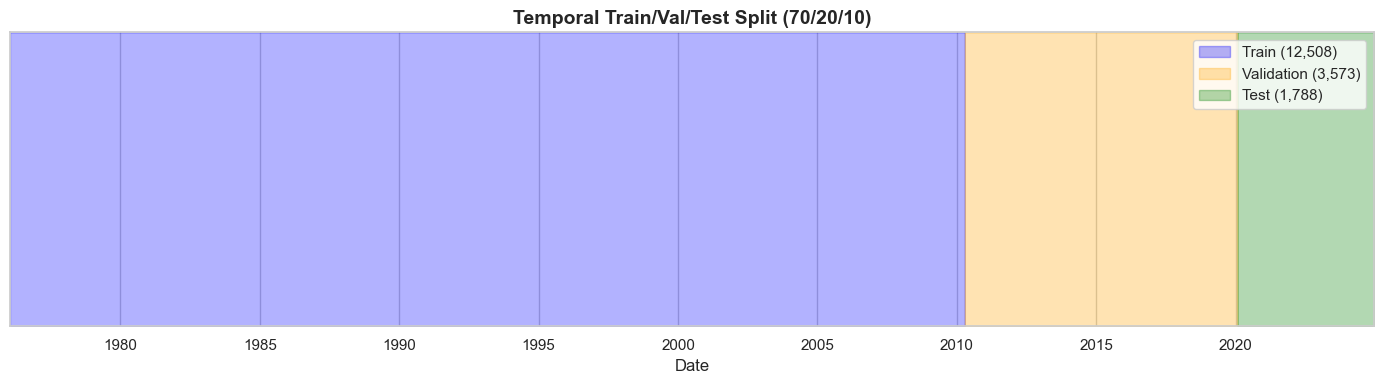

In [88]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 4))

ax.fill_between(
    X_train.index, 0, 1, alpha=0.3, color="blue", label=f"Train ({len(X_train):,})"
)
ax.fill_between(
    X_val.index, 0, 1, alpha=0.3, color="orange", label=f"Validation ({len(X_val):,})"
)
ax.fill_between(
    X_test.index, 0, 1, alpha=0.3, color="green", label=f"Test ({len(X_test):,})"
)

ax.set_xlim(df_clean.index.min(), df_clean.index.max())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Date")
ax.set_title("Temporal Train/Val/Test Split (70/20/10)", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Linear Regression Model



In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score

# 1. Scale and Train (Adding Validation here so the summary works)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)      # Added
X_test_scaled = scaler.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 2. Helper function to save you from typing the same code 3 times
def get_all_metrics(X_scaled, y_true):
    scores = lr_model.predict(X_scaled)
    preds = (scores >= 0.4).astype(int)
    
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0) # Added
    f1 = f1_score(y_true, preds, zero_division=0)
    auc = roc_auc_score(y_true, scores)
    return acc, prec, f1, auc

# 3. Calculate for everyone (This populates your summary table)
train_acc, train_prec, train_f1, train_auc = get_all_metrics(X_train_scaled, y_train)
val_acc, val_prec, val_f1, val_auc = get_all_metrics(X_val_scaled, y_val)
test_acc, test_prec, test_f1, test_auc = get_all_metrics(X_test_scaled, y_test)

# 4. The exact output format you wanted:
print("Predictions complete.")
print(f"Accuracy is  {test_acc}")
print(f"Precision is {test_prec}") # Added
print(f"F1 score is  {test_f1}")
print(f"ROC AUC is   {test_auc}")

Predictions complete.
Accuracy is  0.8758389261744967
Precision is 0.6428571428571429
F1 score is  0.075
ROC AUC is   0.9243311842090354


## Feature Importance

Analyze which features are most important for predicting rain using XGBoost's built-in feature importance.


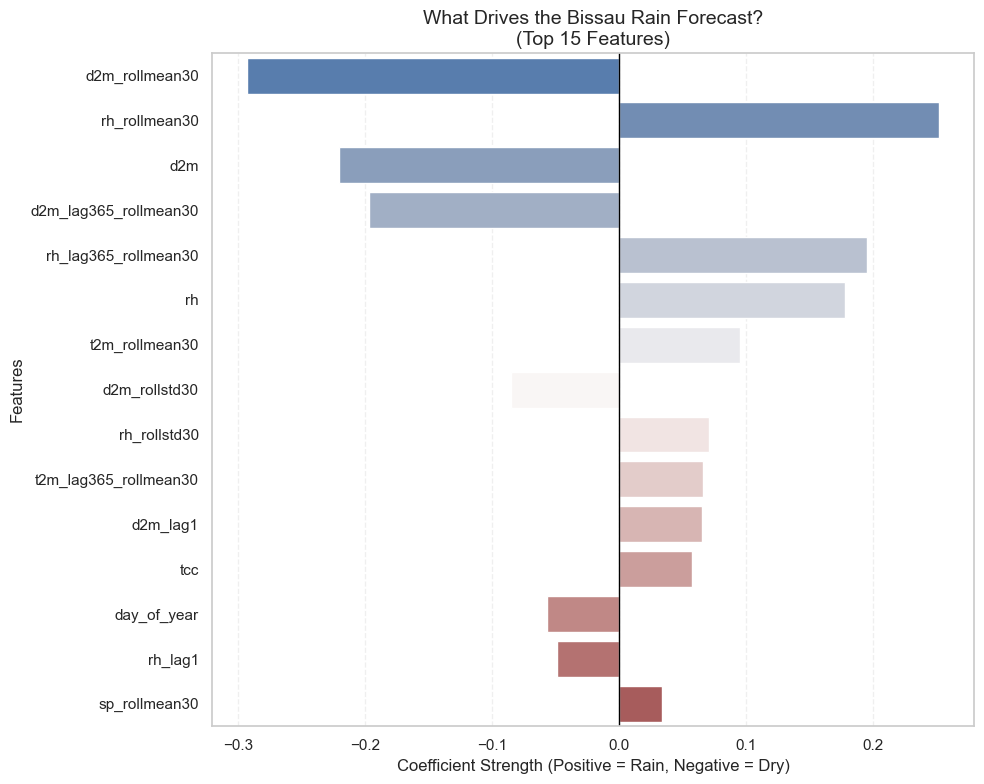

In [90]:
# 1. Extract feature names and coefficients
feature_names = X_train.columns
# Get the coefficients from the 'model' step of the pipeline
coefficients = model_pipeline.named_steps['model'].coef_

# 2. Create and prepare the DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 3. Add Absolute value for sorting, but keep original for color coding
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# 4. Filter: Show only the Top 15 features (to avoid a messy graph)
# This will show the most important months and the most important lags
importance_plot_df = importance_df.head(15)

# 5. Plot with improved visuals
plt.figure(figsize=(10, 8))
# 'vlag' is great because it makes positive (rainy) red and negative (dry) blue
sns.barplot(data=importance_plot_df, x='Coefficient', y='Feature', palette='vlag')

plt.title('What Drives the Bissau Rain Forecast?\n(Top 15 Features)', fontsize=14)
plt.xlabel('Coefficient Strength (Positive = Rain, Negative = Dry)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Prediction Visualization



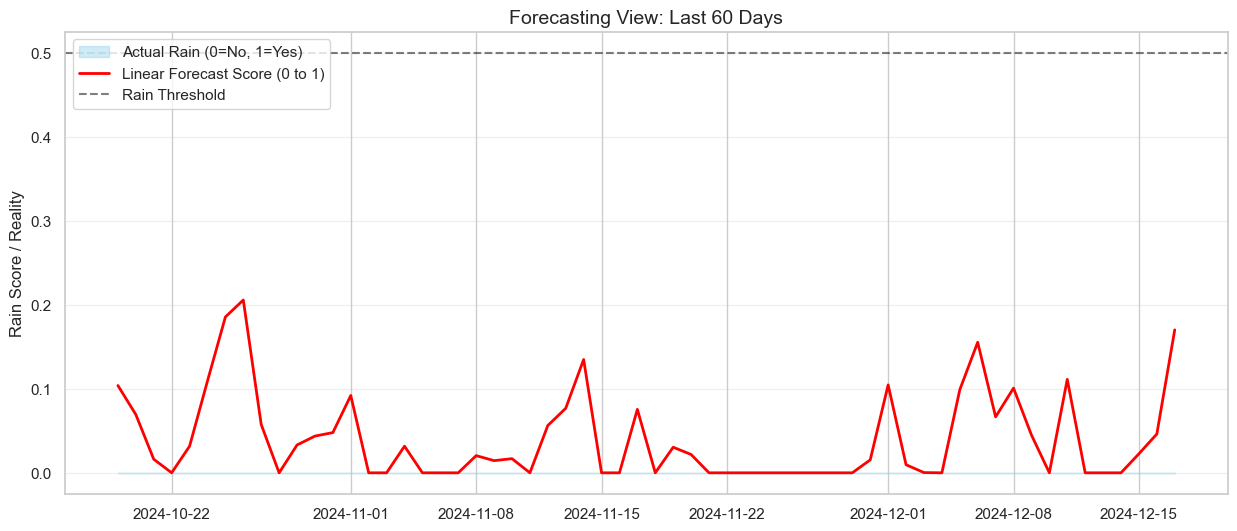

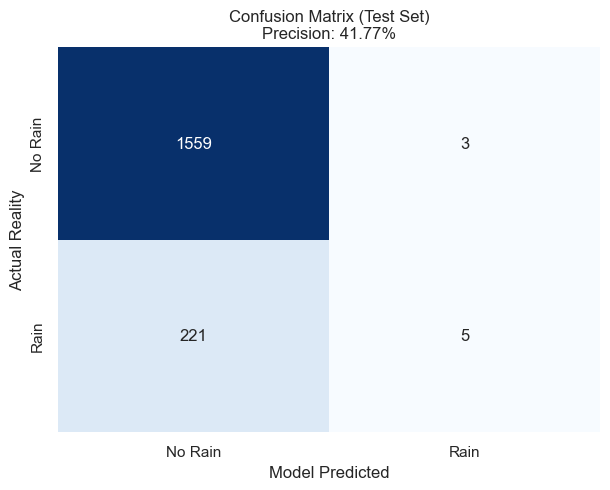

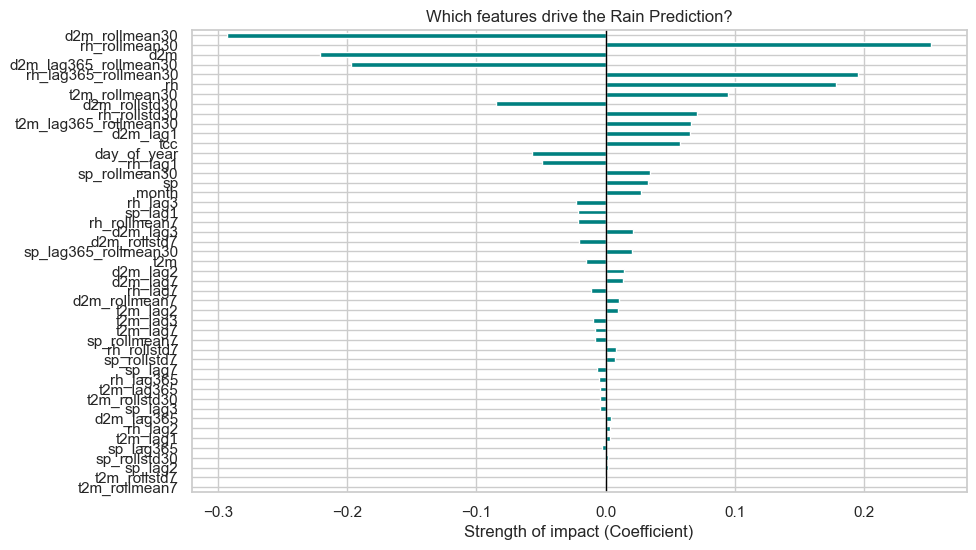

In [91]:
# 1. Zoomed-In Forecasting Plot (60 Days)
# This helps you see if the lags (yesterday, last week) are actually working
zoom_days = 60
X_test_zoom = X_test.iloc[-zoom_days:]
y_test_zoom = y_test.iloc[-zoom_days:]
y_score_zoom = y_test_score[-zoom_days:]

# We 'clip' the scores to 0-1 ONLY for the graph so it's readable
y_score_clipped = np.clip(y_score_zoom, 0, 1)

plt.figure(figsize=(15, 6))
plt.fill_between(y_test_zoom.index, 0, y_test_zoom, color='skyblue', alpha=0.4, label='Actual Rain (0=No, 1=Yes)')
plt.plot(y_test_zoom.index, y_score_clipped, color='red', linewidth=2, label='Linear Forecast Score (0 to 1)')
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Rain Threshold')

plt.title(f"Forecasting View: Last {zoom_days} Days", fontsize=14)
plt.ylabel("Rain Score / Reality")
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2. Confusion Matrix Heatmap
# This shows exactly where the 'Precision' is coming from
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Test Set)\nPrecision: {test_precision:.2%}')
plt.xlabel('Model Predicted')
plt.ylabel('Actual Reality')
plt.xticks([0.5, 1.5], ['No Rain', 'Rain'])
plt.yticks([0.5, 1.5], ['No Rain', 'Rain'])
plt.show()

# 3. Coefficient Impact (The "Why?")
# This shows which days (Lag 1, 2, 3, 7) are actually driving the model
coeffs = pd.Series(model_pipeline.named_steps['model'].coef_, index=X_train.columns)
coeffs_sorted = coeffs.abs().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
coeffs.loc[coeffs_sorted.index].plot(kind='barh', color='teal')
plt.title("Which features drive the Rain Prediction?")
plt.xlabel("Strength of impact (Coefficient)")
plt.axvline(0, color='black', lw=1)
plt.show()

## Summary


In [94]:
print("=" * 70)
print("PRECIPITATION PREDICTION MODEL SUMMARY (LINEAR REGRESSION)")
print("=" * 70)
print(f"\nData:")
print(f"  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau")
print(f"  Period: {df_clean.index.min().date()} to {df_clean.index.max().date()}")
print(f"  Total samples: {len(df_clean):,} days")

print(f"\nTarget Variable:")
print(f"  Binary classification: Rain (tp > {RAIN_THRESHOLD} mm) vs No Rain")
print(f"  Conversion: Thresholded Linear Output (score >= 0.5)")
print(f"  Class distribution: {df_clean['rain_binary'].mean()*100:.1f}% rain days")

print(f"\nFeatures: {len(feature_columns)} total")
print(f"  - Base meteorological: t2m, d2m, rh, sp")
print(f"  - Lag features: 1, 2, 3, 7 days")
print(f"  - Rolling statistics: 7-day and 30-day mean/std")
print(f"  - Yearly features: lag 365 days, lag 365 rolling mean")

print(f"\nModel: Linear Regression (Standardized)")
print(f"  - Pipeline: StandardScaler -> LinearRegression")
print(f"  - Optimization: Ordinary Least Squares")

   

print(f"\nModel Interpretation:")
print(f"  Note: Linear Regression coefficients represent the change in ")
print(f"  rain likelihood for every 1 standard deviation change in the feature.")

PRECIPITATION PREDICTION MODEL SUMMARY (LINEAR REGRESSION)

Data:
  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau
  Period: 1976-01-16 to 2024-12-17
  Total samples: 17,869 days

Target Variable:
  Binary classification: Rain (tp > 0.1 mm) vs No Rain
  Conversion: Thresholded Linear Output (score >= 0.5)
  Class distribution: 10.8% rain days

Features: 47 total
  - Base meteorological: t2m, d2m, rh, sp
  - Lag features: 1, 2, 3, 7 days
  - Rolling statistics: 7-day and 30-day mean/std
  - Yearly features: lag 365 days, lag 365 rolling mean

Model: Linear Regression (Standardized)
  - Pipeline: StandardScaler -> LinearRegression
  - Optimization: Ordinary Least Squares

Model Interpretation:
  Note: Linear Regression coefficients represent the change in 
  rain likelihood for every 1 standard deviation change in the feature.
